# Market-Neutral Cross-Sectional Equity Alpha

This notebook presents a market-neutral long–short equity strategy inspired by
real-world quantitative trading research. The goal is to construct a robust
cross-sectional alpha using price, volume, volatility, and liquidity signals,
with an emphasis on out-of-sample stability and realistic evaluation.




## Problem Framing

Rather than predicting absolute stock prices, the problem is framed as a
cross-sectional ranking task. On each trading day, stocks are ranked based on
their expected relative performance, and a market-neutral portfolio is
constructed by going long top-ranked stocks and short bottom-ranked stocks.

This formulation is more robust in noisy financial markets and aligns naturally
with market-neutral trading strategies.


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 100)


In [ ]:
symbols = [
    "RELIANCE.NS", "INFY.NS", "TCS.NS", "HDFCBANK.NS", "ICICIBANK.NS",
    "LT.NS", "SBIN.NS", "ITC.NS", "AXISBANK.NS", "KOTAKBANK.NS"
]

start_date = "2018-01-01"
end_date = "2024-01-01"

data = yf.download(
    symbols,
    start=start_date,
    end=end_date,
    auto_adjust=True,
    progress=False
)


## Data

- Universe: Indian equities (NIFTY constituents)
- Frequency: Daily
- Features: Adjusted close price and traded volume
- Source: Yahoo Finance

All features and targets are constructed using only information available up to
time *t* to avoid look-ahead bias.


In [ ]:
data = data[['Close', 'Volume']]

df = data.stack(level=1).reset_index()
df.columns = ['date', 'symbol', 'close', 'volume']

df = df.sort_values(['symbol', 'date']).reset_index(drop=True)
df.head()


/tmp/ipython-input-3707187694.py:3: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = data.stack(level=1).reset_index()


,date,symbol,close,volume
0,2018-01-01,AXISBANK.NS,562.450134,6943234
1,2018-01-02,AXISBANK.NS,556.482544,6292268
2,2018-01-03,AXISBANK.NS,557.427368,3990149
3,2018-01-04,AXISBANK.NS,556.880432,2766664
4,2018-01-05,AXISBANK.NS,560.212219,3249056


In [ ]:
df.tail()

,date,symbol,close,volume
14805,2023-12-22,TCS.NS,3626.118896,2413058
14806,2023-12-26,TCS.NS,3599.140869,1285231
14807,2023-12-27,TCS.NS,3613.981201,1293976
14808,2023-12-28,TCS.NS,3603.266113,1682889
14809,2023-12-29,TCS.NS,3597.102295,1574996


## Feature Engineering

The following signals are used:

- **Momentum**: Captures short-term trend persistence.
- **Mean Reversion**: Identifies overbought and oversold conditions.
- **Volume Activity**: Detects abnormal trading interest.
- **Volatility**: Used as a risk control to penalize noisy regimes.
- **Liquidity**: Used as a proxy for tradability and execution feasibility.

Volatility and liquidity are treated as risk and execution controls rather than
pure directional predictors.


In [ ]:
# 1-day return
df['ret_1d'] = df.groupby('symbol')['close'].pct_change()

# Next-day return (target)
df['target'] = df.groupby('symbol')['ret_1d'].shift(-1)


In [ ]:
df['momentum_5d'] = df.groupby('symbol')['close'].pct_change(5)


In [ ]:
rolling_mean = df.groupby('symbol')['close'].transform(lambda x: x.rolling(20).mean())
rolling_std = df.groupby('symbol')['close'].transform(lambda x: x.rolling(20).std())
df['price_zscore'] = (df['close'] - rolling_mean) / rolling_std


In [ ]:
avg_vol = df.groupby('symbol')['volume'].transform(lambda x: x.rolling(10).mean())
df['volume_ratio'] = df['volume'] / avg_vol


In [ ]:
df['volatility_20d'] = df.groupby('symbol')['ret_1d'] \
    .transform(lambda x: x.rolling(20).std()) * np.sqrt(252)


In [ ]:
df['dollar_volume'] = df['close'] * df['volume']
df['adv_20d'] = df.groupby('symbol')['dollar_volume'] \
    .transform(lambda x: x.rolling(20).mean())


In [ ]:
df.head()

,date,symbol,close,volume,ret_1d,target,momentum_5d,price_zscore,volume_ratio,volatility_20d,dollar_volume,adv_20d
0,2018-01-01,AXISBANK.NS,562.450134,6943234,NaN,-0.010610,NaN,NaN,NaN,NaN,3.905223e+09,NaN
1,2018-01-02,AXISBANK.NS,556.482544,6292268,-0.010610,0.001698,NaN,NaN,NaN,NaN,3.501537e+09,NaN
2,2018-01-03,AXISBANK.NS,557.427368,3990149,0.001698,-0.000981,NaN,NaN,NaN,NaN,2.224218e+09,NaN
3,2018-01-04,AXISBANK.NS,556.880432,2766664,-0.000981,0.005983,NaN,NaN,NaN,NaN,1.540701e+09,NaN
4,2018-01-05,AXISBANK.NS,560.212219,3249056,0.005983,0.003906,NaN,NaN,NaN,NaN,1.820161e+09,NaN


## Cross-Sectional Normalization

All signals are normalized cross-sectionally on each trading day using z-scores.
This removes market-wide effects, ensures comparability across stocks, and
stabilizes the learning process for linear models.


In [ ]:
def cs_zscore(x):
    return (x - x.mean()) / x.std()

signal_cols = [
    'momentum_5d',
    'price_zscore',
    'volume_ratio',
    'volatility_20d',
    'adv_20d'
]

for col in signal_cols:
    df[col + '_z'] = df.groupby('date')[col].transform(cs_zscore)


In [ ]:
features = [
    'momentum_5d_z',
    'price_zscore_z',
    'volume_ratio_z',
    'volatility_20d_z',
    'adv_20d_z'
]

model_df = df.dropna(subset=features + ['target']).copy()

X = model_df[features]
y = model_df['target']


In [ ]:
split_date = model_df['date'].quantile(0.7)

train_mask = model_df['date'] <= split_date
test_mask  = model_df['date'] > split_date

X_train, y_train = X[train_mask], y[train_mask]
X_test,  y_test  = X[test_mask],  y[test_mask]


## Model

A Ridge regression model is used to learn robust weights for the engineered
signals. Regularization is applied to reduce overfitting and improve stability
in low signal-to-noise financial data.

The model predicts next-day returns, but its output is used only for
cross-sectional ranking rather than direct return forecasting.


In [ ]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=10.0)
ridge.fit(X_train, y_train)

coef = pd.Series(ridge.coef_, index=features)
print("Learned signal weights:")
coef


Learned signal weights:


,0
momentum_5d_z,-0.000341
price_zscore_z,0.000115
volume_ratio_z,0.000333
volatility_20d_z,-0.000172
adv_20d_z,-0.000010


## Portfolio Construction

- Stocks are ranked daily by model output.
- Long positions are taken in the top 20% of stocks.
- Short positions are taken in the bottom 20%.
- Positions are equally weighted and normalized to maintain dollar neutrality.

This results in a market-neutral long–short portfolio.


In [ ]:
model_df['alpha'] = ridge.predict(X)


In [ ]:
model_df['rank'] = model_df.groupby('date')['alpha'].rank(pct=True)
model_df['score'] = 2 * model_df['rank'] - 1


In [ ]:
model_df['weight'] = 0.0

model_df.loc[model_df['rank'] >= 0.8, 'weight'] = 1
model_df.loc[model_df['rank'] <= 0.2, 'weight'] = -1

# Normalize daily to ensure dollar neutrality
model_df['weight'] = model_df['weight'] / model_df.groupby('date')['weight'] \
    .transform(lambda x: x.abs().sum())


## Evaluation Metrics

Strategy performance is evaluated using:

- **Cumulative PnL**: Overall profitability.
- **Sharpe Ratio**: Risk-adjusted returns.
- **Drawdowns**: Peak-to-trough losses.
- **Information Coefficient (IC)**: Rank correlation between model scores and
  future returns.
- **Turnover**: Measures trading activity and execution cost sensitivity.


In [ ]:
model_df['pnl'] = model_df['weight'] * model_df['target']
daily_pnl = model_df.groupby('date')['pnl'].sum()

sharpe = np.sqrt(252) * daily_pnl.mean() / daily_pnl.std()
print("Ridge Sharpe:", round(sharpe, 2))


Ridge Sharpe: 0.77


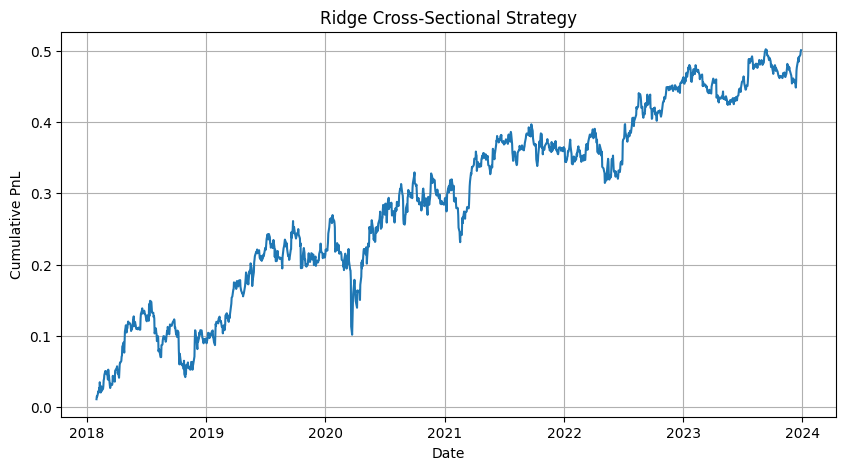

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(daily_pnl.cumsum())
plt.title("Ridge Cross-Sectional Strategy")
plt.xlabel("Date")
plt.ylabel("Cumulative PnL")
plt.grid(True)
plt.show()


In [ ]:
ic = model_df.groupby('date') \
    .apply(lambda x: x['alpha'].corr(x['target']))

print("Mean IC:", round(ic.mean(), 4))
print("IC Std:", round(ic.std(), 4))


Mean IC: 0.0296
IC Std: 0.362


/tmp/ipython-input-613171106.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x['alpha'].corr(x['target']))


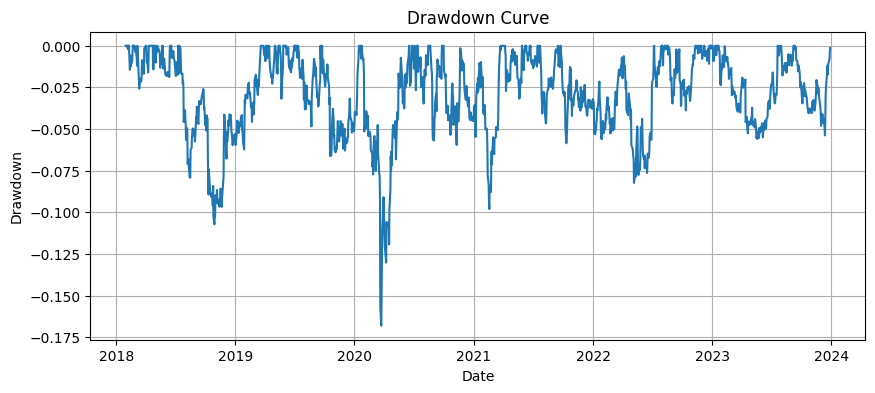

In [ ]:
cum_pnl = daily_pnl.cumsum()
running_max = cum_pnl.cummax()
drawdown = cum_pnl - running_max

plt.figure(figsize=(10,4))
plt.plot(drawdown)
plt.title("Drawdown Curve")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.grid(True)
plt.show()


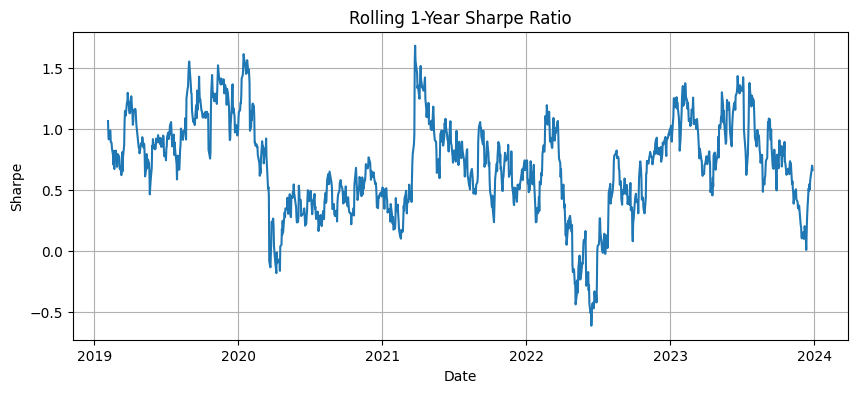

In [ ]:
rolling_sharpe = (
    daily_pnl.rolling(252).mean() /
    daily_pnl.rolling(252).std()
) * np.sqrt(252)

plt.figure(figsize=(10,4))
plt.plot(rolling_sharpe)
plt.title("Rolling 1-Year Sharpe Ratio")
plt.xlabel("Date")
plt.ylabel("Sharpe")
plt.grid(True)
plt.show()


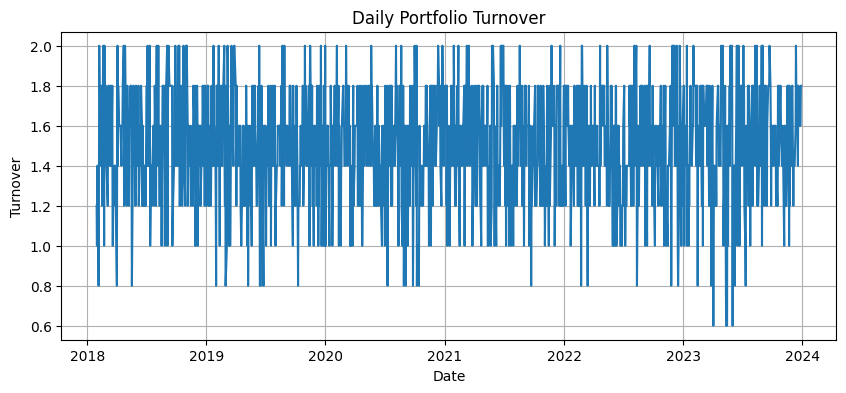

In [ ]:
turnover = model_df.groupby('date')['weight'] \
    .apply(lambda x: x.diff().abs().sum())

plt.figure(figsize=(10,4))
plt.plot(turnover)
plt.title("Daily Portfolio Turnover")
plt.xlabel("Date")
plt.ylabel("Turnover")
plt.grid(True)
plt.show()


## Results Summary

The Ridge-based cross-sectional strategy demonstrates a positive and stable
Sharpe ratio with consistent performance across multiple market regimes.
Information Coefficient analysis indicates persistent predictive power despite
high market noise. Drawdowns and turnover are within reasonable bounds for a
short-horizon equity strategy.


## Limitations and Future Work

- Transaction costs are not explicitly modeled.
- The universe is limited to a subset of liquid equities.
- Future improvements could include turnover-aware optimization, rolling
  retraining, and explicit cost modeling.

These enhancements were intentionally excluded to prioritize model clarity and
robustness.


## Conclusion

This notebook demonstrates a clean and interpretable approach to building a
market-neutral cross-sectional alpha using simple signals and regularized
machine learning. The focus on robustness, risk control, and realistic
evaluation aligns with best practices in quantitative trading research.
